# Example-based verifications

In [1]:
# general tools
import os
import sys
import h5py
import numpy as np
import netCDF4 as nc
from glob import glob
from datetime import datetime, timedelta

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [5]:
with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
    lon_CCPA = h5io['lon_CCPA'][...]
    lat_CCPA = h5io['lat_CCPA'][...]
    elev_CCPA = h5io['elev_CCPA'][...]
    land_mask_CCPA = h5io['land_mask_CCPA'][...]


grid_shape = land_mask_CCPA.shape
ocean_mask_CCPA = land_mask_CCPA == 0.0
elev_CCPA[ocean_mask_CCPA] = np.nan


# SPC climatology from Dr. Sobash
with nc.Dataset(NCAR_dir+'climo_severe_2hr_all.nc') as ncio:
    climo = ncio['climo'][...]

with h5py.File(NCAR_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]

climo_mean = np.nanmean(climo[0, ...], axis=(0, 1))
climo_mean[~land_mask_80km] = np.nan

In [6]:
q_bins = np.array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
                   0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
                   0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
                   0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
                   0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
                   0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
                   0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
                   0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
                   0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 
                   0.99, 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 1.0])

with h5py.File(camp_dir+'CCPA/CCPA_CDFs_lead_2002_2019.hdf', 'r') as h5io:
    CCPA_CDFs = h5io['CCPA_CDFs_lead'][...]

In [7]:
CCPA_CDFs_06 = CCPA_CDFs[:, 0, ...]
CCPA_CDFs_18 = CCPA_CDFs[:, 2, ...] 
# np.nanmean(CCPA_CDFs, axis=1)

In [8]:
def get_quantile_from_thres(CDF, thres):
    grid_shape = CDF.shape[1:]
    out = np.empty(grid_shape); out[...] = np.nan
    
    for ix in range(grid_shape[0]):
        for iy in range(grid_shape[1]):
            temp_CDF = CDF[:, ix, iy]
            if np.isnan(temp_CDF[-1]) or temp_CDF[-1] <= thres:
                out[ix, iy] = np.nan
            else:
                out[ix, iy] = np.interp(thres, temp_CDF, q_bins)
    return out

In [9]:
p40_06 = get_quantile_from_thres(CCPA_CDFs_06, 40)
p40_18 = get_quantile_from_thres(CCPA_CDFs_18, 40)

In [10]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

plt.rcParams['hatch.color'] = 'k'

In [11]:
A = plt.cm.terrain(np.linspace(0, 1, 100))
terrain_c = A[20:]

cmap_terrain = mcolors.ListedColormap(terrain_c, 'terrain_cmap')
cmap_terrain.set_over(terrain_c[-1, :])
cmap_terrain.set_under(terrain_c[0, :])
cmap_terrain.set_bad('w')

cmap_pct, A = gu.precip_cmap()
cmap_prob = cmap_pct
none_map = mcolors.ListedColormap(['none'])

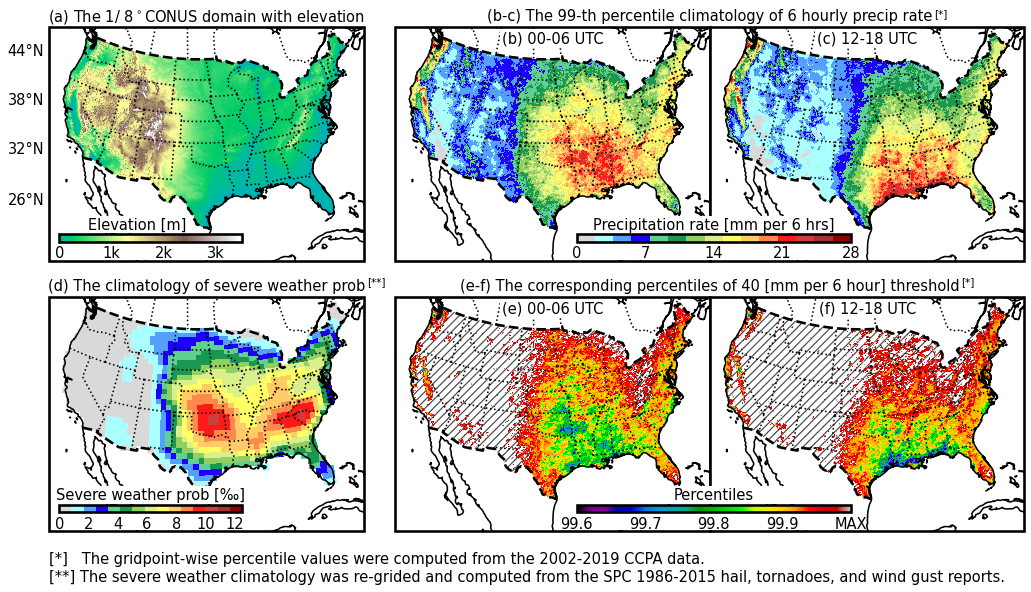

In [12]:
edge_ = [-118, -77.5, 22, 51.5] #[-118, -77.5, 25.5, 51.5]

fig = plt.figure(figsize=(13, 6.8), dpi=dpi_)
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 0.125, 1], width_ratios=[1, 0.1, 1, 1])

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

ax0 = plt.subplot(gs[0, 0], projection=proj_)
ax1 = plt.subplot(gs[0, 2], projection=proj_)
ax2 = plt.subplot(gs[0, 3], projection=proj_)
ax3 = plt.subplot(gs[2, 0], projection=proj_)
ax4 = plt.subplot(gs[2, 2], projection=proj_)
ax5 = plt.subplot(gs[2, 3], projection=proj_)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

AX = [ax0, ax1, ax2, ax3, ax4, ax5]

for n, ax in enumerate(AX):
    ax.set_extent(edge_, ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)    
    ax.spines['geo'].set_linewidth(2.5)

    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None

    if n == 0:
        GL.left_labels = True
        GL.bottom_labels = False
    # elif n == 5:
    #     GL.left_labels = False
    #     GL.bottom_labels = True   
    else:
        GL.left_labels = False
        GL.bottom_labels = False   
    
    GL.xlocator = mticker.FixedLocator(np.arange(-113, -75, 10))
    GL.ylocator = mticker.FixedLocator(np.arange(26, 52, 6))
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False


CS0 = ax0.pcolormesh(lon_CCPA, lat_CCPA, elev_CCPA, vmin=0, vmax=3500, 
                     cmap=cmap_terrain, transform=ccrs.PlateCarree())

CS1 = ax1.pcolormesh(lon_CCPA, lat_CCPA, CCPA_CDFs_06[99, ...], vmin=0, vmax=28, 
                     cmap=cmap_pct, transform=ccrs.PlateCarree())
CS2 = ax2.pcolormesh(lon_CCPA, lat_CCPA, CCPA_CDFs_18[99, ...], vmin=0, vmax=28, 
                     cmap=cmap_pct, transform=ccrs.PlateCarree())

CS3 = ax3.pcolormesh(lon_80km, lat_80km, 1e3*climo_mean, vmin=0, vmax=12.5, 
                     cmap=cmap_prob, transform=ccrs.PlateCarree())

CS4 = ax4.pcolormesh(lon_CCPA, lat_CCPA, 1e2*p40_06, vmin=99.6, vmax=100, 
                     cmap=plt.cm.nipy_spectral, transform=ccrs.PlateCarree())
CS5 = ax5.pcolormesh(lon_CCPA, lat_CCPA, 1e2*p40_18, vmin=99.6, vmax=100, 
                     cmap=plt.cm.nipy_spectral, transform=ccrs.PlateCarree())

label_mask = np.isnan(p40_06).astype(float)
label_mask[ocean_mask_CCPA] = 0
label_mask = np.ma.array(label_mask, mask=label_mask==0)
ax4.pcolor(lon_CCPA, lat_CCPA, label_mask, cmap=none_map, edgecolor='k', 
           hatch='///', lw=0.0, zorder=7, transform=ccrs.PlateCarree())

label_mask = np.isnan(p40_18).astype(float)
label_mask[ocean_mask_CCPA] = 0
label_mask = np.ma.array(label_mask, mask=label_mask==0)
ax5.pcolor(lon_CCPA, lat_CCPA, label_mask, cmap=none_map, edgecolor='k', 
           hatch='///', lw=0.0, zorder=7, transform=ccrs.PlateCarree())


loc_x = 0.025
loc_y = 0.537
loc_y2 = 0.007
w_ = 1/3.1 - 0.01
h_ = 0.05

# ======================================================================================== #
# P1 colorbar
ax_base = fig.add_axes([0.01, loc_y, 0.6*w_, h_])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)

cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS0, orientation='horizontal', ticks=[0, 1000, 2000, 3000], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xticklabels(['0', '1k', '2k', '3k']);

ax_w1 = fig.add_axes([0.04, loc_y+h_+2e-3, 0.3*w_, 0.7*h_])
[j.set_linewidth(0.0) for j in ax_w1.spines.values()]
ax_w1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                  labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_w1.text(0.0, 0.5, 'Elevation [m]', ha='left', va='center', fontsize=14, transform=ax_w1.transAxes);


# ======================================================================================== #
# P2-3 colorbar
ax_base = fig.add_axes([0.525, loc_y, w_, h_])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)

cax = inset_axes(ax_base, height='30%', width='90%', borderpad=0, loc=9)
CBar = plt.colorbar(CS1, orientation='horizontal', ticks=[0, 7, 14, 21, 28], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xticklabels(['0', '7', '14', '21', '28']);

ax_w2 = fig.add_axes([0.525+0.03, loc_y+h_+2e-3, w_-0.06, 0.7*h_])
[j.set_linewidth(0.0) for j in ax_w2.spines.values()]
ax_w2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                  labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_w2.text(0.5, 0.5, 'Precipitation rate [mm per 6 hrs]', ha='center', va='center', fontsize=14, transform=ax_w2.transAxes);


# ======================================================================================== #
# P4 colorbar

ax_base = fig.add_axes([0.01, loc_y2, 0.6*w_, h_])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)

cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS3, orientation='horizontal', ticks=[0, 2, 4, 6, 8, 10, 12, 14], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
#CBar.ax.set_xticklabels(['0', '1k', '2k', '3k']);

ax_w3 = fig.add_axes([0.01, loc_y2+h_+2e-3, 0.6*w_, 0.7*h_])
[j.set_linewidth(0.0) for j in ax_w3.spines.values()]
ax_w3.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                  labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_w3.text(0.5, 0.5, 'Severe weather prob [‰]', ha='center', va='center', fontsize=14, transform=ax_w3.transAxes);

# ======================================================================================== #
# P5-6 colorbar
ax_base = fig.add_axes([0.525, loc_y2, w_, h_])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)

cax = inset_axes(ax_base, height='30%', width='90%', borderpad=0, loc=9)
CBar = plt.colorbar(CS4, orientation='horizontal', ticks=[99.6, 99.7, 99.8, 99.9, 100], cax=cax) # 
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xticklabels(['99.6', '99.7', '99.8', '99.9', 'MAX']);

ax_w4 = fig.add_axes([0.525+0.03, loc_y2+h_+2e-3, w_-0.06, 0.7*h_])
[j.set_linewidth(0.0) for j in ax_w4.spines.values()]
ax_w4.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                  labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_w4.text(0.5, 0.5, 'Percentiles', ha='center', va='center', fontsize=14, transform=ax_w4.transAxes);

# ======================================================================================== #
ax0.set_title('(a) The 1/ 8$^\circ$CONUS domain with elevation', fontsize=14)

ax1.set_title('(b-c) The 99-th percentile climatology of 6 hourly precip rate', ha='center', x=1.0, fontsize=14)
handle = ax1.text(0.5, 0.98, '(b) 00-06 UTC', ha='center', va='top', fontsize=14, transform=ax1.transAxes)
handle.set_bbox(dict(facecolor='w', pad=2, linewidth=0, zorder=7))
handle = ax2.text(0.5, 0.98, '(c) 12-18 UTC', ha='center', va='top', fontsize=14, transform=ax2.transAxes)
handle.set_bbox(dict(facecolor='w', pad=2, linewidth=0, zorder=7))

ax3.set_title('(d) The climatology of severe weather prob', fontsize=14)

ax4.set_title('(e-f) The corresponding percentiles of 40 [mm per 6 hour] threshold', ha='center', x=1.0, fontsize=14)
handle = ax4.text(0.5, 0.98, '(e) 00-06 UTC', ha='center', va='top', fontsize=14, transform=ax4.transAxes)
handle.set_bbox(dict(facecolor='w', pad=2, linewidth=0, zorder=7))
handle = ax5.text(0.5, 0.98, '(f) 12-18 UTC', ha='center', va='top', fontsize=14, transform=ax5.transAxes)
handle.set_bbox(dict(facecolor='w', pad=2, linewidth=0, zorder=7))

# ----------------------------------------------------------------- #
# [*] words

ax_title1 = fig.add_axes([0.907, 1.01, 0.02*9/13, 0.02])
ax_title1.text(0.5, 0.5, '[*]', ha='center', va='center', fontsize=10, transform=ax_title1.transAxes);
ax_title1.set_axis_off()

ax_title2 = fig.add_axes([0.935, 0.485, 0.02*9/13, 0.02])
ax_title2.text(0.5, 0.5, '[*]', ha='center', va='center', fontsize=10, transform=ax_title2.transAxes);
ax_title2.set_axis_off()

ax_title3 = fig.add_axes([0.325, 0.485, 0.03*9/13, 0.02])
ax_title3.text(0.5, 0.5, '[**]', ha='center', va='center', fontsize=10, transform=ax_title3.transAxes);
ax_title3.set_axis_off()

ax_words1 = fig.add_axes([0.0, -0.065+0.01, 0.9, 0.02])
ax_words1.text(0, 1, 
               '[*]   The gridpoint-wise percentile values were computed from the 2002-2019 CCPA data.',
               ha='left', va='top', fontsize=14, transform=ax_words1.transAxes);
ax_words1.set_axis_off()

ax_words2 = fig.add_axes([0.0, -0.1+0.01, 0.9, 0.02])
ax_words2.text(0, 1, 
    '[**] The severe weather climatology was re-grided and computed from the SPC 1986-2015 hail, tornadoes, and wind gust reports.', 
    ha='left', va='top', fontsize=14, transform=ax_words2.transAxes);
ax_words2.set_axis_off()
# ----------------------------------------------------------------- #

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig1_domain_clim.png', format='png', **fig_keys)

### Old version

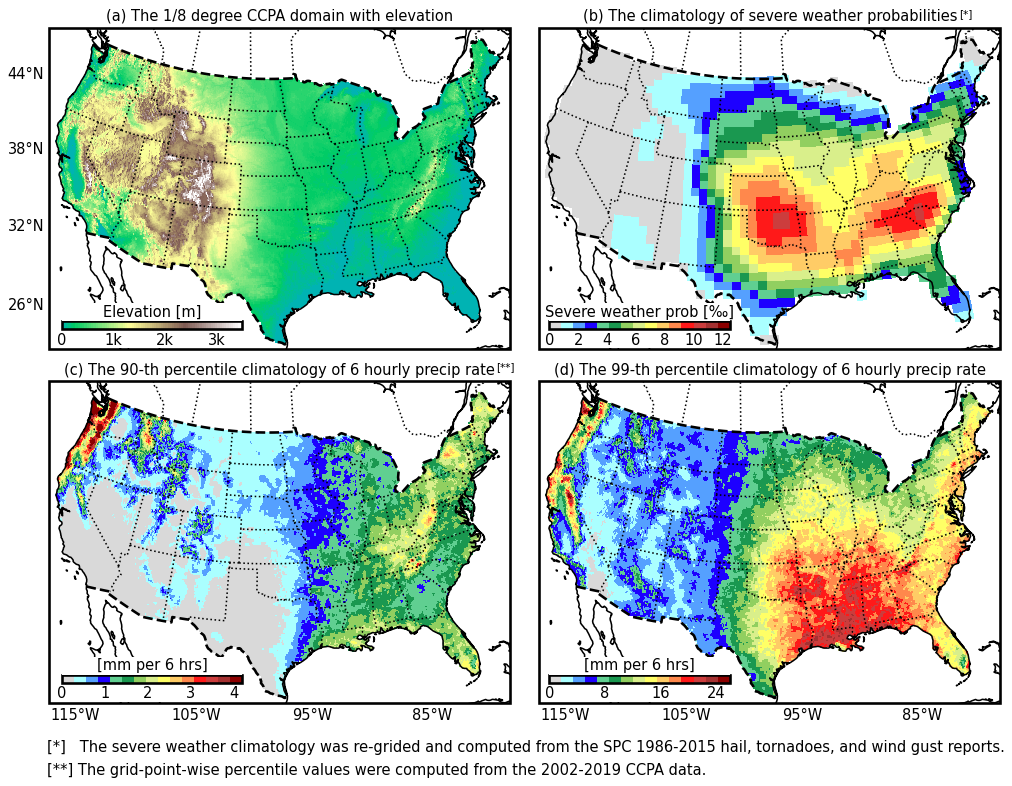

In [10]:
edge_ = [-118, -77.5, 25.5, 51.5]

fig = plt.figure(figsize=(13, 9), dpi=dpi_)
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], width_ratios=[1, 0.01, 1])

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

ax1 = plt.subplot(gs[0, 0], projection=proj_)
ax2 = plt.subplot(gs[0, 2], projection=proj_)
ax3 = plt.subplot(gs[2, 0], projection=proj_)
ax4 = plt.subplot(gs[2, 2], projection=proj_)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

AX = [ax1, ax2, ax3, ax4]

for n, ax in enumerate(AX):
    ax.set_extent(edge_, ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)    
    ax.spines['geo'].set_linewidth(2.5)

    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    
    if n == 0:
        GL.left_labels = True
        GL.bottom_labels = False
    elif n == 1:
        GL.left_labels = False
        GL.bottom_labels = False   
    else:
        GL.left_labels = None
        GL.bottom_labels = True
    
    GL.xlocator = mticker.FixedLocator(np.arange(-115, -75, 10))
    GL.ylocator = mticker.FixedLocator(np.arange(26, 52, 6))
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False

ax1.set_title('(a) The 1/8 degree CCPA domain with elevation', fontsize=14)

ax2.set_title('(b) The climatology of severe weather probabilities', fontsize=14)

ax3.set_title(
    '(c) The 90-th percentile climatology of 6 hourly precip rate', 
    ha='center', fontsize=14)

ax4.set_title(
    '(d) The 99-th percentile climatology of 6 hourly precip rate', 
    ha='center', fontsize=14)

CS0 = ax1.pcolormesh(lon_CCPA, lat_CCPA, elev_CCPA, vmin=0, vmax=3500, 
                     cmap=cmap_terrain, transform=ccrs.PlateCarree())
CS1 = ax2.pcolormesh(lon_80km, lat_80km, 1e3*climo_mean, vmin=0, vmax=12.5, 
                     cmap=cmap_prob, transform=ccrs.PlateCarree())
CS2 = ax3.pcolormesh(lon_CCPA, lat_CCPA, CCPA_CDFs_mean[90, ...], vmin=0, vmax=4.2, 
                     cmap=cmap_pct, transform=ccrs.PlateCarree())
CS3 = ax4.pcolormesh(lon_CCPA, lat_CCPA, CCPA_CDFs_mean[99, ...], vmin=0, vmax=26, 
                     cmap=cmap_pct, transform=ccrs.PlateCarree())

loc_x = 0.025
loc_y = 0.525
loc_y_pad = 0.04
w_ = 0.185
h_ = 0.04
loc_y_gap = 0.5235

ax_base = fig.add_axes([loc_x, loc_y, w_, h_])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
#ax_base.set_axis_off()
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)

cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS0, orientation='horizontal', ticks=[0, 1000, 2000, 3000], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xticklabels(['0', '1k', '2k', '3k']);

ax_w1 = fig.add_axes([loc_x, loc_y+loc_y_pad, w_, h_/3*2])
[j.set_linewidth(0.0) for j in ax_w1.spines.values()]
ax_w1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_w1.text(0.5, 0.5, 'Elevation [m]', ha='center', va='center', fontsize=14, transform=ax_w1.transAxes);

ax_base = fig.add_axes([loc_x+0.5, loc_y, w_, h_])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS1, orientation='horizontal', ticks=[0, 2, 4, 6, 8, 10, 12, 14], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)

ax_w2 = fig.add_axes([loc_x+0.5, loc_y+loc_y_pad, w_, h_/3*2])
[j.set_linewidth(0.0) for j in ax_w2.spines.values()]
ax_w2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_w2.text(0.5, 0.5, 'Severe weather prob [‰]', ha='center', va='center', fontsize=14, transform=ax_w2.transAxes);

ax_base = fig.add_axes([loc_x, loc_y-loc_y_gap, w_, h_])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)

cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS2, orientation='horizontal', ticks=[0, 1, 2, 3, 4], cax=cax) # 
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
# CBar.ax.set_xticklabels(['0', '0.8', '1.6', '2.4']);

ax_w3 = fig.add_axes([loc_x, loc_y+loc_y_pad-loc_y_gap, w_, h_/3*2])
[j.set_linewidth(0.0) for j in ax_w3.spines.values()]
ax_w3.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_w3.text(0.5, 0.5, '[mm per 6 hrs]', ha='center', va='center', fontsize=14, transform=ax_w3.transAxes);

ax_base = fig.add_axes([loc_x+0.5, loc_y-loc_y_gap, w_, h_])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)

cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS3, orientation='horizontal', ticks=[0, 8, 16, 24], cax=cax) # 
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xticklabels(['0', '8', '16', '24']);

ax_w4 = fig.add_axes([loc_x+0.5, loc_y+loc_y_pad-loc_y_gap, w_, h_/3*2])
[j.set_linewidth(0.0) for j in ax_w4.spines.values()]
ax_w4.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_w4.text(0.5, 0.5, '[mm per 6 hrs]', ha='center', va='center', fontsize=14, transform=ax_w4.transAxes);

ax_title1 = fig.add_axes([0.945, 1.01, 0.02*9/13, 0.02])
ax_title1.text(0.5, 0.5, '[*]', ha='center', va='center', fontsize=10, transform=ax_title1.transAxes);
ax_title1.set_axis_off()

ax_title2 = fig.add_axes([0.47, 0.4875, 0.03*9/13, 0.02])
ax_title2.text(0.5, 0.5, '[**]', ha='center', va='center', fontsize=10, transform=ax_title2.transAxes);
ax_title2.set_axis_off()


# ----------------------------------------------------------------- #
# [*] words
ax_words1 = fig.add_axes([0.01, -0.065-0.01, 0.9, 0.02])
ax_words1.text(0, 1, 
               '[*]   The severe weather climatology was re-grided and computed from the SPC 1986-2015 hail, tornadoes, and wind gust reports.', 
               ha='left', va='top', fontsize=14, transform=ax_words1.transAxes);
ax_words1.set_axis_off()

ax_words2 = fig.add_axes([0.01, -0.1-0.01, 0.9, 0.02])
ax_words2.text(0, 1, 
    '[**] The grid-point-wise percentile values were computed from the 2002-2019 CCPA data.', 
    ha='left', va='top', fontsize=14, transform=ax_words2.transAxes);
ax_words2.set_axis_off()
# ----------------------------------------------------------------- #

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig_domain_clim.png', format='png', **fig_keys)